In [1]:
import numpy as np
import sys, os, shutil
import pandas as pd
import collections as cl
import itertools as it
import timeit
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import copy as cp
import pyprojroot as pr
import scipy.stats as scs
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
#Change directory
os.chdir(pr.here("./Data"))
os.getcwd()

'c:\\Users\\yche465\\Desktop\\AIM 1\\Codes\\PrEP-Traj-Clustering\\Data'

### Create categorical variables used for stratified sampling

In [3]:
#Import appended person-level covariates
PERSON_DATA=pd.read_csv("PersonVars_appended.csv")

In [4]:
#Create class labels (based on quintiles) for continuous attributes
Avg_Copay_Cutoff=20
PERSON_DATA['Age_at_init_CAT']=pd.cut(PERSON_DATA['Age_at_init'],
                                     bins=np.percentile(PERSON_DATA['Age_at_init'],[0,33.3,66.7,100]),
                                     include_lowest=True,
                                     labels=[1,2,3])
PERSON_DATA['Average_copay_CAT']=pd.cut(PERSON_DATA['Average_copay'],
                                     bins=[min(PERSON_DATA['Average_copay']),Avg_Copay_Cutoff,max(PERSON_DATA['Average_copay'])],
                                     include_lowest=True,
                                     labels=[0,1])
PERSON_DATA['Dur_subopt_CAT']=pd.cut(PERSON_DATA['Dur_subopt'],
                                     bins=np.percentile(PERSON_DATA['Dur_subopt'],[0,33.3,66.7,100]),
                                     include_lowest=True,
                                     labels=[1,2,3])
PERSON_DATA['Num_protect_interval_CAT']=pd.cut(PERSON_DATA['Num_protect_interval'],
                                     bins=[1,3,max(PERSON_DATA['Num_protect_interval'])],
                                     include_lowest=True,
                                     labels=[0,1])

In [5]:
print("Num_protect_interval_CAT: MIN =",min(PERSON_DATA.loc[PERSON_DATA['Num_protect_interval_CAT']==0,'Num_protect_interval']))
print("Num_protect_interval_CAT: MAX =",max(PERSON_DATA.loc[PERSON_DATA['Num_protect_interval_CAT']==0,'Num_protect_interval']))
print("Num_protect_interval_CAT: MIN =",min(PERSON_DATA.loc[PERSON_DATA['Num_protect_interval_CAT']==1,'Num_protect_interval']))
print("Num_protect_interval_CAT: MAX =",max(PERSON_DATA.loc[PERSON_DATA['Num_protect_interval_CAT']==1,'Num_protect_interval']))

Num_protect_interval_CAT: MIN = 1
Num_protect_interval_CAT: MAX = 3
Num_protect_interval_CAT: MIN = 4
Num_protect_interval_CAT: MAX = 6


In [6]:
#Check if categorical variable for average copay is created correctly
print("Avg Copay CAT=0: MIN =",min(PERSON_DATA.loc[PERSON_DATA['Average_copay_CAT']==0,'Average_copay']))
print("Avg Copay CAT=0: MAX =",max(PERSON_DATA.loc[PERSON_DATA['Average_copay_CAT']==0,'Average_copay']))
print("Avg Copay CAT=1: MIN =",min(PERSON_DATA.loc[PERSON_DATA['Average_copay_CAT']==1,'Average_copay']))
print("Avg Copay CAT=1: MAX =",max(PERSON_DATA.loc[PERSON_DATA['Average_copay_CAT']==1,'Average_copay']))


Avg Copay CAT=0: MIN = 0.0014466757625993
Avg Copay CAT=0: MAX = 19.999495211848075
Avg Copay CAT=1: MIN = 20.00519949246824
Avg Copay CAT=1: MAX = 181.13185749472308


In [7]:
#Check for missing values
PERSON_DATA.loc[PERSON_DATA.isna().any(axis=1)]

,Unnamed: 0,ID,Age_at_init,Primary_payer,Average_copay,Pharmacy_type,Dur_subopt,Num_protect_interval,Age_at_init_CAT,Average_copay_CAT,Dur_subopt_CAT,Num_protect_interval_CAT


### Implement stratified sampling

In [16]:
#Import the original sero-protection dataset 
SeroProtect = np.loadtxt('SeroProtect_13k.txt', usecols=range(104), delimiter=",")
orig_size=len(SeroProtect)

#Import the original PMC dataset 
PMC=np.loadtxt('PMC_13k.txt', usecols=range(103), delimiter=",")

In [17]:
#Check sample size of individual stratum 
pd.options.display.max_rows = 999
working_size=4000
strat_cols=['Age_at_init_CAT','Average_copay_CAT','Primary_payer','Dur_subopt_CAT']

print(PERSON_DATA.groupby(strat_cols).size()/orig_size*working_size)

Age_at_init_CAT  Average_copay_CAT  Primary_payer  Dur_subopt_CAT
1                0                  0              1                 249.846154
                                                   2                 262.461538
                                                   3                 248.307692
                                    1              1                  47.384615
                                                   2                  45.230769
                                                   3                  42.461538
                                    2              1                  17.230769
                                                   2                  17.538462
                                                   3                  16.923077
                 1                  0              1                 155.692308
                                                   2                 142.153846
                                                   3  

In [18]:
#Conduct stratified sampling
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=working_size/orig_size, random_state=42)

for nonwork_index, work_index in stratified_split.split(PERSON_DATA, 
                                                        PERSON_DATA[strat_cols]):
    strat_nonwork_set = PERSON_DATA.loc[nonwork_index]
    strat_work_set = PERSON_DATA.loc[work_index]

In [19]:
#Check the presence of duplicated ID
len(np.unique(strat_work_set['ID']))!=working_size

False

In [20]:
strat_cols.append('Num_protect_interval_CAT')

In [21]:
#Check distributions of columns between original and sampled datasets
strat_cols
for i in strat_cols:
    X=pd.DataFrame()
    X['Original']=PERSON_DATA[i].value_counts() / orig_size
    X['Working']=strat_work_set[i].value_counts() / working_size
    print(i)
    print(X)

Age_at_init_CAT
   Original  Working
1  0.373923   0.3735
2  0.320846   0.3210
3  0.305231   0.3055
Average_copay_CAT
   Original  Working
0  0.628308    0.628
1  0.371692    0.372
Primary_payer
   Original  Working
0  0.804923   0.8045
1  0.145769   0.1460
2  0.049308   0.0495
Dur_subopt_CAT
   Original  Working
1  0.338231  0.33825
2  0.332923  0.33325
3  0.328846  0.32850
Num_protect_interval_CAT
   Original  Working
0  0.966462  0.96425
1  0.033538  0.03575


In [22]:
Sampled_SeroProtect=SeroProtect[work_index]

# Export sampled PrEP trajectories matrix
f= open("SeroProtect_4k.txt","w+")
for i in range(len(Sampled_SeroProtect)):
    for j in range(104):
        if j == 103:
            f.write("%s\n" % (Sampled_SeroProtect[i][j]))
        else:
            f.write("%s," % (Sampled_SeroProtect[i][j]))
f.close()


### Descriptive statistics: sampled dataset

In [33]:
def intv_attr(PMC):
    # Create the matrix of suboptimal sero-protection (i.e., PMC<0.57)
    SubProtect=PMC<4/7
    #Create the following time series arrays:
    ## possible PrEP cessation start time (in week)
    ## possible PrEP cessation end time (in week)
    ## possible PrEP use interval start time (in week)
    ## possible PrEP use iterval end time (in week)
    CESS_START=[]
    CESS_END=[]
    PrEP_START=[]
    PrEP_END=[]
    
    for k in range(len(SubProtect)):
        cess_start=[]
        prep_start=[0]
        cess_end=[]
        prep_end=[]
        for i in range(1,103):
            if SubProtect[k][i]==True and SubProtect[k][i-1]==False:
                cess_start.append(i)
                prep_end.append(i)

            elif SubProtect[k][i]==False and SubProtect[k][i-1]==True:
                cess_end.append(i)
                prep_start.append(i)

        CESS_START.append(cess_start)
        PrEP_START.append(prep_start)
        CESS_END.append(cess_end)
        PrEP_END.append(prep_end)

    #set the Week 103 as the end point of any unclosed PrEP use interval 
    for i in range(len(SubProtect)):
        if len(PrEP_START[i])>len(PrEP_END[i]):
            PrEP_END[i].append(103)

    for i in range(len(SubProtect)):   
        #if more cessation start date than end date, then set the Week 103 as the end point of any unclosed 
        #cessation interval 
        if len(CESS_START[i])>len(CESS_END[i]):
            CESS_END[i].append(103)
        
        #else if more cessation end date than start date, then set the Week 0 as the start point of 
        #any unclosed cessation interval 
        elif len(CESS_START[i])<len(CESS_END[i]):
            CESS_START[i].insert(0,0)
        #else if equal number of cessation start and end dates & the first end date predate the first start date 
        # then add Week 0 as the first start date and Week 103 as the last end date
        elif len(CESS_START[i])==len(CESS_END[i]) and len(CESS_START[i])>0 and CESS_START[i][0]>CESS_END[i][0]:
            CESS_START[i].insert(0,0)
            CESS_END[i].append(103)
        #else if it is cessation all the way through the entire follow-up period (i.e., no initial start and end dates 
        #but subpoptimal sero-protection time series is >0) then add Week 0 and 103 as the start and end dates, respectively
        elif len(CESS_START[i])==0 and len(CESS_START[i])==0 and sum(SubProtect[i])>0:
            CESS_START[i].insert(0,0)
            CESS_END[i].append(103)
    return CESS_START, CESS_END, PrEP_START, PrEP_END

In [34]:
Sampled_PMC=PMC[work_index]
Sampled_SubProtect=Sampled_PMC<4/7

CESS_START,CESS_END,PrEP_START,PrEP_END = intv_attr(Sampled_PMC)
#Create list object: the duration of 1st, 2nd, 3rd PrEP protective intervals
IntervalLen_1=[None]*len(Sampled_PMC)
IntervalLen_2=[None]*len(Sampled_PMC)
IntervalLen_3=[None]*len(Sampled_PMC)
for i in range(len(Sampled_PMC)):
    IntervalLen_1[i]=PrEP_END[i][0]-PrEP_START[i][0]
    if(len(PrEP_START[i])>1):
        IntervalLen_2[i]=PrEP_END[i][1]-PrEP_START[i][1]
    if(len(PrEP_START[i])>2):
        IntervalLen_3[i]=PrEP_END[i][2]-PrEP_START[i][2]    
#Create list object: the total duration spent in sub-optimal sero-protection 
Total_SubP_Dur=np.array([sum(Sampled_SubProtect[i]) for i in range(len(Sampled_PMC))])
#Create list object: the number of the number of sero-protection interval
Num_Protect_Int=np.array([len(PrEP_START[i]) for i in range(len(Sampled_PMC))])

<ipython-input-35-e995d3a7e2cd>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1=sns.distplot(Total_SubP_Dur, ax=ax[0][0])
<ipython-input-35-e995d3a7e2cd>:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2=sns.distplot(IntervalLen_1, ax=ax[0][1])
<ipython-input-35-e995d3a7e2cd>:23: UserWarning: 

`distplot` is a 

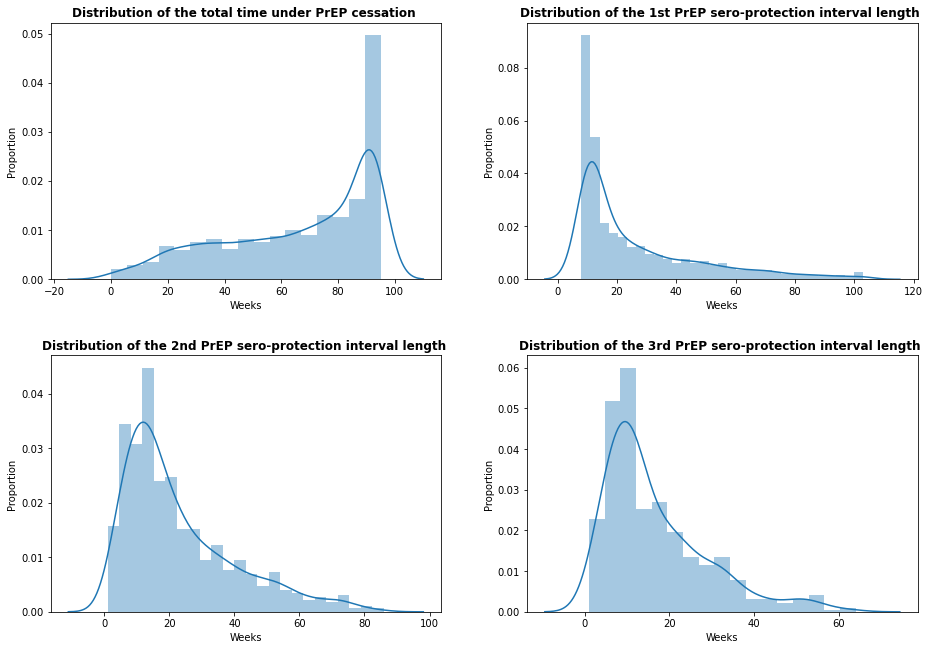

In [35]:
#Figures
os.chdir(pr.here("./Figures"))
os.getcwd()

IntervalLen_2trim=[x for x in IntervalLen_2 if x is not None]
IntervalLen_3trim=[x for x in IntervalLen_3 if x is not None]


fig,ax =  plt.subplots(2,2,figsize=(14,10))
fig.tight_layout(pad=5.5)

#Distribution of the total duration spent in PrEP cessation (i.e., suboptimal sero-protection)
ax1=sns.distplot(Total_SubP_Dur, ax=ax[0][0])
ax1.set(xlabel="Weeks", ylabel="Proportion")
ax1.set_title("Distribution of the total time under PrEP cessation ",fontweight='bold', y=1.025)

#Distribution of 1st PrEP sero-protective intervals
ax2=sns.distplot(IntervalLen_1, ax=ax[0][1])
ax2.set(xlabel="Weeks", ylabel="Proportion")
ax2.set_title("Distribution of the 1st PrEP sero-protection interval length ",fontweight='bold', y=1.025)

#Distribution of 2nd PrEP sero-protective intervals
ax3=sns.distplot(IntervalLen_2trim, ax=ax[1][0])
ax3.set(xlabel="Weeks", ylabel="Proportion")
ax3.set_title("Distribution of the 2nd PrEP sero-protection interval length ",fontweight='bold', y=1.025)

#Distribution of 2nd PrEP sero-protective intervals
ax4=sns.distplot(IntervalLen_3trim, ax=ax[1][1])
ax4.set(xlabel="Weeks", ylabel="Proportion")
ax4.set_title("Distribution of the 3rd PrEP sero-protection interval length ",fontweight='bold', y=1.025)

plt.savefig('Distplot_sampled.png', bbox_inches='tight')

In [36]:
Tab_Lens_sampled=pd.DataFrame({"Attribute":["Total time under sub-optimal PrEP protection",
                                          "Length of 1st PrEP protective interval",
                                          "Length of 2nd PrEP protective interval",
                                          "Length of 3rd PrEP protective interval"],    
                              "Mean":[np.mean(Total_SubP_Dur),
                                      np.mean(IntervalLen_1),
                                      np.mean(IntervalLen_2trim),
                                      np.mean(IntervalLen_3trim)],
                              "SD":[np.std(Total_SubP_Dur),
                                    np.std(IntervalLen_1),
                                    np.std(IntervalLen_2trim),
                                    np.std(IntervalLen_3trim)],
                              "Median":[np.quantile(Total_SubP_Dur, 0.5),
                                        np.quantile(IntervalLen_1, 0.5),
                                        np.quantile(IntervalLen_2trim, 0.5),
                                        np.quantile(IntervalLen_3trim, 0.5)],
                              "IQR:25%":[np.quantile(Total_SubP_Dur, 0.25),
                                        np.quantile(IntervalLen_1, 0.25),
                                        np.quantile(IntervalLen_2trim, 0.25),
                                        np.quantile(IntervalLen_3trim, 0.25)],
                              "IQR:75%":[np.quantile(Total_SubP_Dur, 0.75),
                                        np.quantile(IntervalLen_1, 0.75),
                                        np.quantile(IntervalLen_2trim, 0.75),
                                        np.quantile(IntervalLen_3trim, 0.75)]
                             })

Tab_Lens_sampled

,Attribute,Mean,SD,Median,IQR:25%,IQR:75%
0,Total time under sub-optimal PrEP protection,65.798250,26.310417,74.0,45.0,90.0
1,Length of 1st PrEP protective interval,26.578500,21.540783,17.0,11.0,36.0
2,Length of 2nd PrEP protective interval,22.980603,17.143924,17.0,11.0,31.0
3,Length of 3rd PrEP protective interval,16.727447,12.167836,13.0,8.0,23.0


In [37]:
#Categorical distribution of number of PrEP prescription interval
freq=dict(cl.Counter(Num_Protect_Int))
Tab_ProtectInt_sampled = pd.DataFrame(list(freq.items()),columns = ['Number of PrEP protective interval','N']).sort_values(by=['Number of PrEP protective interval']) 
Tab_ProtectInt_sampled['%']=np.around(Tab_ProtectInt_sampled['N']/len(Num_Protect_Int)*100,1)
Tab_ProtectInt_sampled

,Number of PrEP protective interval,N,%
0,1,2608,65.2
1,2,871,21.8
2,3,378,9.4
3,4,125,3.1
4,5,16,0.4
5,6,2,0.0


In [44]:
#Export descriptive statistics (original data)
os.chdir(pr.here("./Export"))
Descript_sampled={"Length_attributes":Tab_Lens_sampled, "Num_Protect_Intervals": Tab_ProtectInt_sampled}
import pickle
pickle_out=open("Descript_sampled","wb")
pickle.dump(Descript_sampled,pickle_out)
pickle_out.close()